# 결측치 처리

In [1]:
import pandas as pd

# CSV 파일 읽기
df = pd.read_csv(r'C:\Users\82106\Desktop\과제테스트\repair2.csv')

In [2]:
df.isnull().sum()

caseID                     0
taskID                     2
originator                 2
eventtype                  5
contact                12262
RepairType             12335
objectKey              12335
RepairInternally       12335
EstimatedRepairTime    12335
RepairCode             12335
RepairOK               11408
date                      13
time                      13
dtype: int64

In [3]:
extern_eventtypes = df.loc[df['taskID'] == 'ExternRepair', 'eventtype'].unique()
print("ExternRepair의 eventtype 값들:", extern_eventtypes)

ExternRepair의 eventtype 값들: ['start']


외부 수리는 start 시간 밖에없어서, 처리기간 확인을 할수없음

In [4]:
#'taskID', 'originator', 'eventtype' 결측치 존재 행 삭제
df = df.dropna(subset=['taskID', 'originator', 'eventtype','date','time'])

In [5]:
# 이외의 결측치는 NaN으로 채우기
df[['contact', 'RepairType', 'objectKey', 'RepairInternally', 'EstimatedRepairTime', 'RepairCode', 'RepairOK']]= df[['contact', 'RepairType', 'objectKey', 'RepairInternally', 'EstimatedRepairTime', 'RepairCode', 'RepairOK']].fillna(pd.NA)

# 이상치 처리
- start와 complete의 시간차이가 많이 나는 행 삭제

In [6]:
# date와 time 컬럼을 합쳐 datetime 컬럼 생성
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str), errors='coerce')

# caseID와 taskID를 기준으로 피벗하여 start와 complete 이벤트를 하나의 행으로 결합
pivot = df.pivot_table(index=['caseID', 'taskID'],
                       columns='eventtype',
                       values='datetime',
                       aggfunc='min')

# start와 complete 모두 존재하는 행에 대해 시간 차이 계산 
mask_both = pivot['start'].notna() & pivot['complete'].notna()
pivot.loc[mask_both, 'time_diff'] = pivot.loc[mask_both, 'complete'] - pivot.loc[mask_both, 'start']

# 시간 차이가 너무 큰 행 삭제 
threshold = pd.Timedelta(days=100)
indices_to_remove = pivot[mask_both & (pivot['time_diff'] > threshold)].index

# 해당 caseID와 taskID에 해당하는 행을 원본 데이터프레임에서 삭제
df = df[~df.set_index(['caseID', 'taskID']).index.isin(indices_to_remove)]

# start와 complete 관련 전처리

In [7]:
#한글폰트
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 경로 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 여기서 'malgun.ttf'는 예시로 사용한 것이며, 실제 한글 폰트 파일로 변경해야 합니다.
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

##### start & complete 분포 시각화

Complete only: 5702
Start only: 134
Complete before Start: 230
Start before Complete: 3185


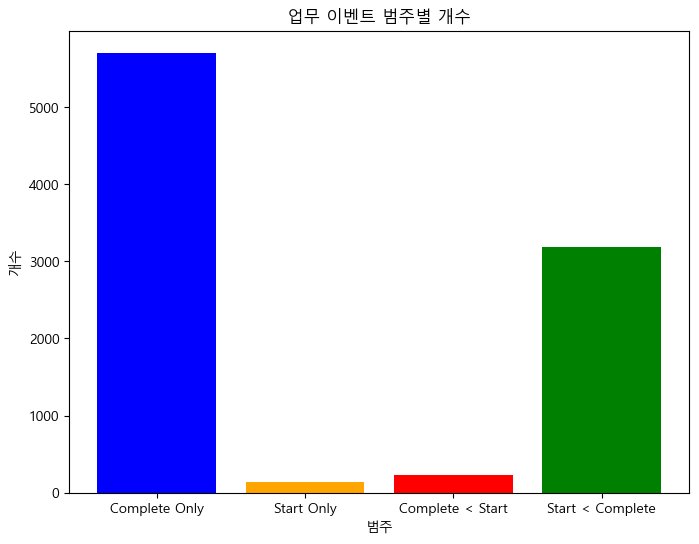

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# date와 time 컬럼을 합쳐서 datetime 컬럼 생성
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str), errors='coerce')

# caseID와 taskID를 기준으로 피벗하여 start와 complete 이벤트를 한 행으로 결합
pivot = df.pivot_table(index=['caseID', 'taskID'], 
                       columns='eventtype', 
                       values='datetime', 
                       aggfunc='min')

#각 범주의 개수 계산
# complete만 있는 경우
complete_only = pivot[pivot.get('start').isna() & pivot.get('complete').notna()].shape[0]
# start만 있는 경우
start_only    = pivot[pivot.get('complete').isna() & pivot.get('start').notna()].shape[0]
# 양쪽 모두 존재하는 경우 중 complete가 start보다 먼저인 경우 (비정상적인 경우)
complete_before_start = pivot[(pivot.get('start').notna()) & (pivot.get('complete').notna()) & (pivot['complete'] < pivot['start'])].shape[0]
# 양쪽 모두 존재하는 경우 중 start가 complete보다 먼저인 경우 (정상적인 경우)
start_before_complete = pivot[(pivot.get('start').notna()) & (pivot.get('complete').notna()) & (pivot['start'] < pivot['complete'])].shape[0]

# 각 범주의 개수 출력
print("Complete only:", complete_only)
print("Start only:", start_only)
print("Complete before Start:", complete_before_start)
print("Start before Complete:", start_before_complete)

#막대 그래프로 시각화
categories = ['Complete Only', 'Start Only', 'Complete < Start', 'Start < Complete']
counts = [complete_only, start_only, complete_before_start, start_before_complete]

plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color=['blue', 'orange', 'red', 'green'])
plt.xlabel('범주')
plt.ylabel('개수')
plt.title('업무 이벤트 범주별 개수')
plt.show()


#### Start before Complete: 3188 행(처리시간 계산 가능) 만 남기고 모두 삭제

In [9]:
# 기존 pivot 테이블을 사용하여 "Start before Complete"에 해당하는 (caseID, taskID) 추출
valid_indices = pivot[
    (pivot.get('start').notna()) & 
    (pivot.get('complete').notna()) & 
    (pivot['start'] < pivot['complete'])
].index

# valid_indices (MultiIndex)를 DataFrame으로 변환
valid_keys = pd.DataFrame(valid_indices.tolist(), columns=['caseID', 'taskID'])

# 3. 원본 데이터프레임와 valid_keys를 inner merge하여 해당하는 행만 남기기
df = pd.merge(df, valid_keys, on=['caseID', 'taskID'], how='inner')


orginator 에서 system은 start가 존재하지않고 complete만 존재하기때문에 모두 삭제됨.

Start before Complete: 3188 행의 taskID를 활용해 업무처리속도 계산

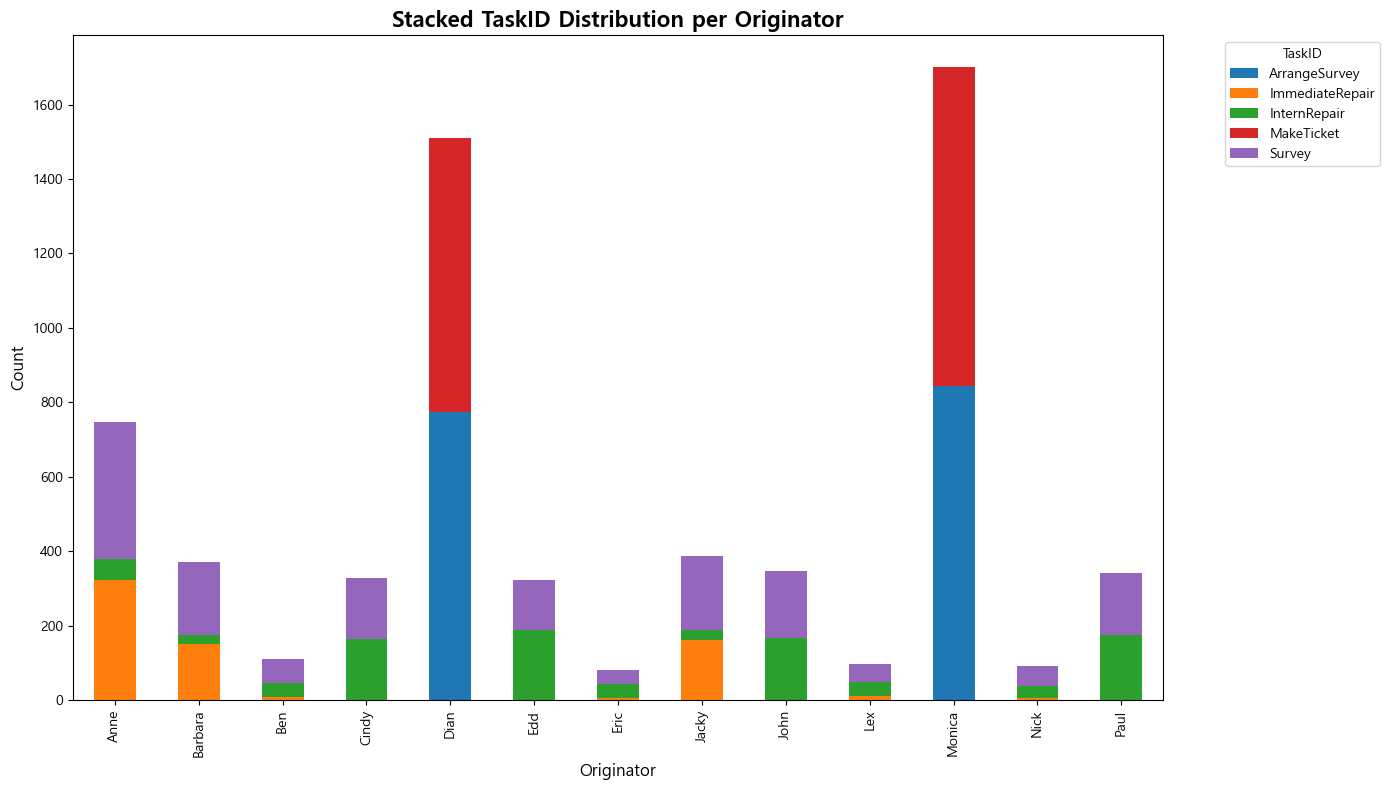

   originator           taskID  count
0        Anne  ImmediateRepair    324
1        Anne     InternRepair     54
2        Anne           Survey    368
3     Barbara  ImmediateRepair    152
4     Barbara     InternRepair     24
5     Barbara           Survey    196
6         Ben  ImmediateRepair      8
7         Ben     InternRepair     38
8         Ben           Survey     64
9       Cindy     InternRepair    164
10      Cindy           Survey    164
11       Dian    ArrangeSurvey    775
12       Dian       MakeTicket    736
13        Edd     InternRepair    188
14        Edd           Survey    136
15       Eric  ImmediateRepair      6
16       Eric     InternRepair     36
17       Eric           Survey     40
18      Jacky  ImmediateRepair    162
19      Jacky     InternRepair     26
20      Jacky           Survey    200
21       John     InternRepair    166
22       John           Survey    180
23        Lex  ImmediateRepair     10
24        Lex     InternRepair     38
25        Le

In [10]:
# originator와 taskID별 빈도수 계산
originator_task_counts =df.groupby(['originator','taskID']).size().reset_index(name = 'count')

#피벗 테이블 생성
originator_task_pivot = originator_task_counts.pivot(index = 'originator', columns = 'taskID', values = 'count')

# 스택형 막대 그래프 그리기
originator_task_pivot.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title("Stacked TaskID Distribution per Originator", fontsize=16, fontweight='bold')
plt.xlabel("Originator", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="TaskID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print(originator_task_counts)

System이 가장 많은 일을 처리하며, 주로 티켓제작 이나 전송을 담당한다.

# Originator의 taskID별 업무 처리 속도

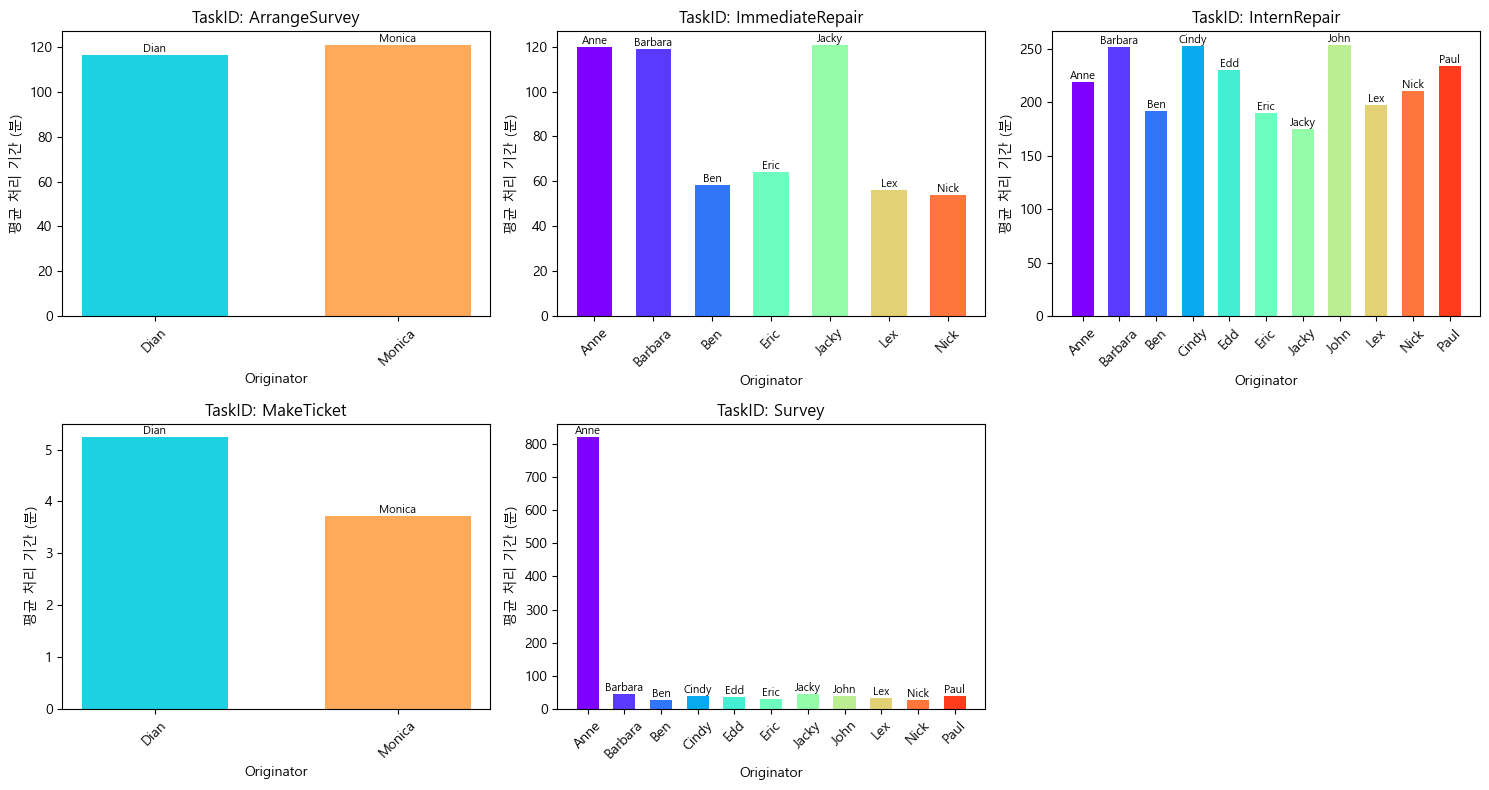

In [11]:
import math
import matplotlib.cm as cm
import numpy as np

# date와 time 컬럼을 합쳐서 datetime 컬럼 생성
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str), errors='coerce')

# caseID와 taskID를 기준으로 피벗하여 start와 complete 이벤트를 한 행으로 결합
pivot = df.pivot_table(index=['caseID', 'taskID'], 
                       columns='eventtype', 
                       values='datetime', 
                       aggfunc='min').reset_index()

# start 이벤트의 originator 정보 추출 (중복 제거)
originator_df = df[df['eventtype'] == 'start'][['caseID', 'taskID', 'originator']].drop_duplicates()

# 피벗 테이블과 originator 정보를 병합하여 start, complete, originator 정보를 확보
df_proc = pd.merge(pivot, originator_df, on=['caseID', 'taskID'], how='left')

# 업무 처리 기간 계산 (complete - start)
df_proc['processing_time'] = df_proc['complete'] - df_proc['start']

# start와 complete가 모두 있는 행 선택
df_proc = df_proc.dropna(subset=['processing_time'])

# 처리 기간을 분 단위로 변환
df_proc['processing_time_minutes'] = df_proc['processing_time'].dt.total_seconds() / 60

# originator와 taskID별 평균 처리 기간 계산
avg_proc = df_proc.groupby(['originator', 'taskID'])['processing_time_minutes'].mean().reset_index()

# 평균 처리 기간이 0인 경우 제거
avg_proc = avg_proc[avg_proc['processing_time_minutes'] != 0]

# 피벗 테이블 생성 (인덱스: taskID, 컬럼: originator)
pivot_df = avg_proc.pivot(index='taskID', columns='originator', values='processing_time_minutes')

# 각 originator별 고유 색상 지정
unique_originators = pivot_df.columns.tolist()
n_originators = len(unique_originators)
colors = {origin: cm.rainbow(i / n_originators) for i, origin in enumerate(unique_originators)}

# taskID별로 개별 그래프(서브플롯) 생성
unique_taskIDs = pivot_df.index.tolist()
n_tasks = len(unique_taskIDs)
ncols = 3  # 한 행에 표시할 그래프 수
nrows = math.ceil(n_tasks / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), squeeze=False)

# 각 taskID에 대해 서브플롯에 막대 그래프 생성
for idx, task in enumerate(unique_taskIDs):
    row = idx // ncols
    col = idx % ncols
    ax = axes[row][col]
    
    # 해당 taskID에 해당하는 데이터 (Series: index=originator, value=평균 처리 기간)
    data = pivot_df.loc[task].dropna()
    
    # x축 위치 설정
    x = np.arange(len(data))
    bar_colors = [colors[origin] for origin in data.index]
    
    # 막대 그래프 그리기
    bars = ax.bar(x, data.values, color=bar_colors, width=0.6)
    
    # 각 막대 위에 originator 이름 표시
    for bar, origin in zip(bars, data.index):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, origin, ha='center', va='bottom', fontsize=8)
    
    ax.set_xticks(x)
    ax.set_xticklabels(data.index, rotation=45)
    ax.set_xlabel('Originator')
    ax.set_ylabel('평균 처리 기간 (분)')
    ax.set_title(f'TaskID: {task}')

# 사용되지 않은 서브플롯 숨기기
for idx in range(n_tasks, nrows * ncols):
    row = idx // ncols
    col = idx % ncols
    fig.delaxes(axes[row][col])
    
plt.tight_layout()
plt.show()


차이가 많이 나는 담당자를 따로 박스플롯으로 이상치 확인

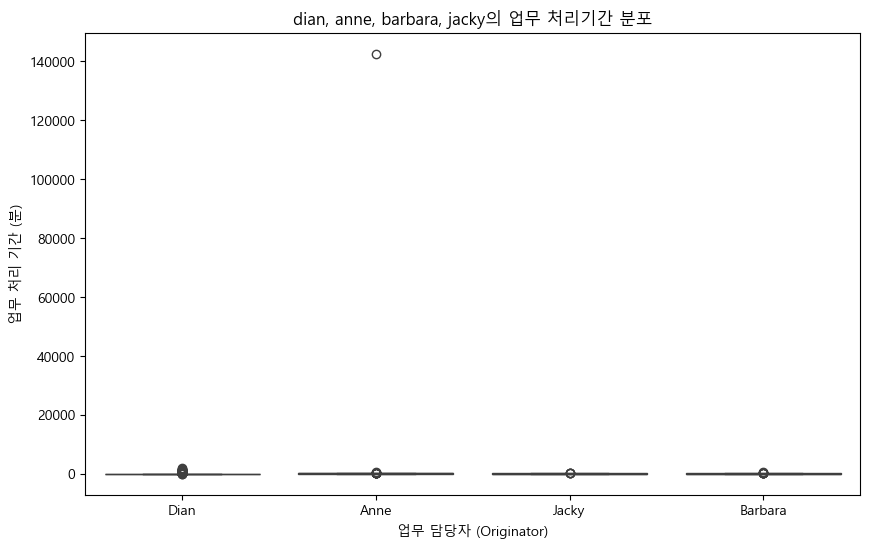

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. date와 time 컬럼을 합쳐서 datetime 컬럼 생성
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str), errors='coerce')

# 2. caseID와 taskID를 기준으로 피벗하여 start와 complete 이벤트의 datetime을 하나의 행으로 결합
pivot_df = df.pivot_table(index=['caseID', 'taskID'], 
                          columns='eventtype', 
                          values='datetime', 
                          aggfunc='min').reset_index()

# 3. start 이벤트의 originator 정보 추출 (중복 제거)
originator_df = df[df['eventtype'] == 'start'][['caseID', 'taskID', 'originator']].drop_duplicates()

# 4. 피벗 테이블과 originator 정보를 병합하여 각 케이스의 start, complete, originator 정보 확보
df_proc = pd.merge(pivot_df, originator_df, on=['caseID', 'taskID'], how='left')

# 5. 업무 처리 기간 계산 (complete - start)를 분 단위로 계산
df_proc['processing_time'] = (df_proc['complete'] - df_proc['start']).dt.total_seconds() / 60

# 6. 관심 있는 originator만 필터링 (dian, anne, barbara, jacky)
target_originators = ['Dian', 'Anne', 'Barbara', 'Jacky']
filtered = df_proc[df_proc['originator'].isin(target_originators)]

# 7. 업무 처리기간 분포를 시각화 (박스플롯 사용)
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered, x='originator', y='processing_time')
plt.xlabel('업무 담당자 (Originator)')
plt.ylabel('업무 처리 기간 (분)')
plt.title('dian, anne, barbara, jacky의 업무 처리기간 분포')
plt.show()

In [13]:
# 'anne'의 업무 처리기간이 20000분 이상인 행을 삭제
df_proc = df_proc[~((df_proc['originator'].str.lower() == 'anne') & (df_proc['processing_time'] >= 20000))]

이상치 제거 후 다시 확인

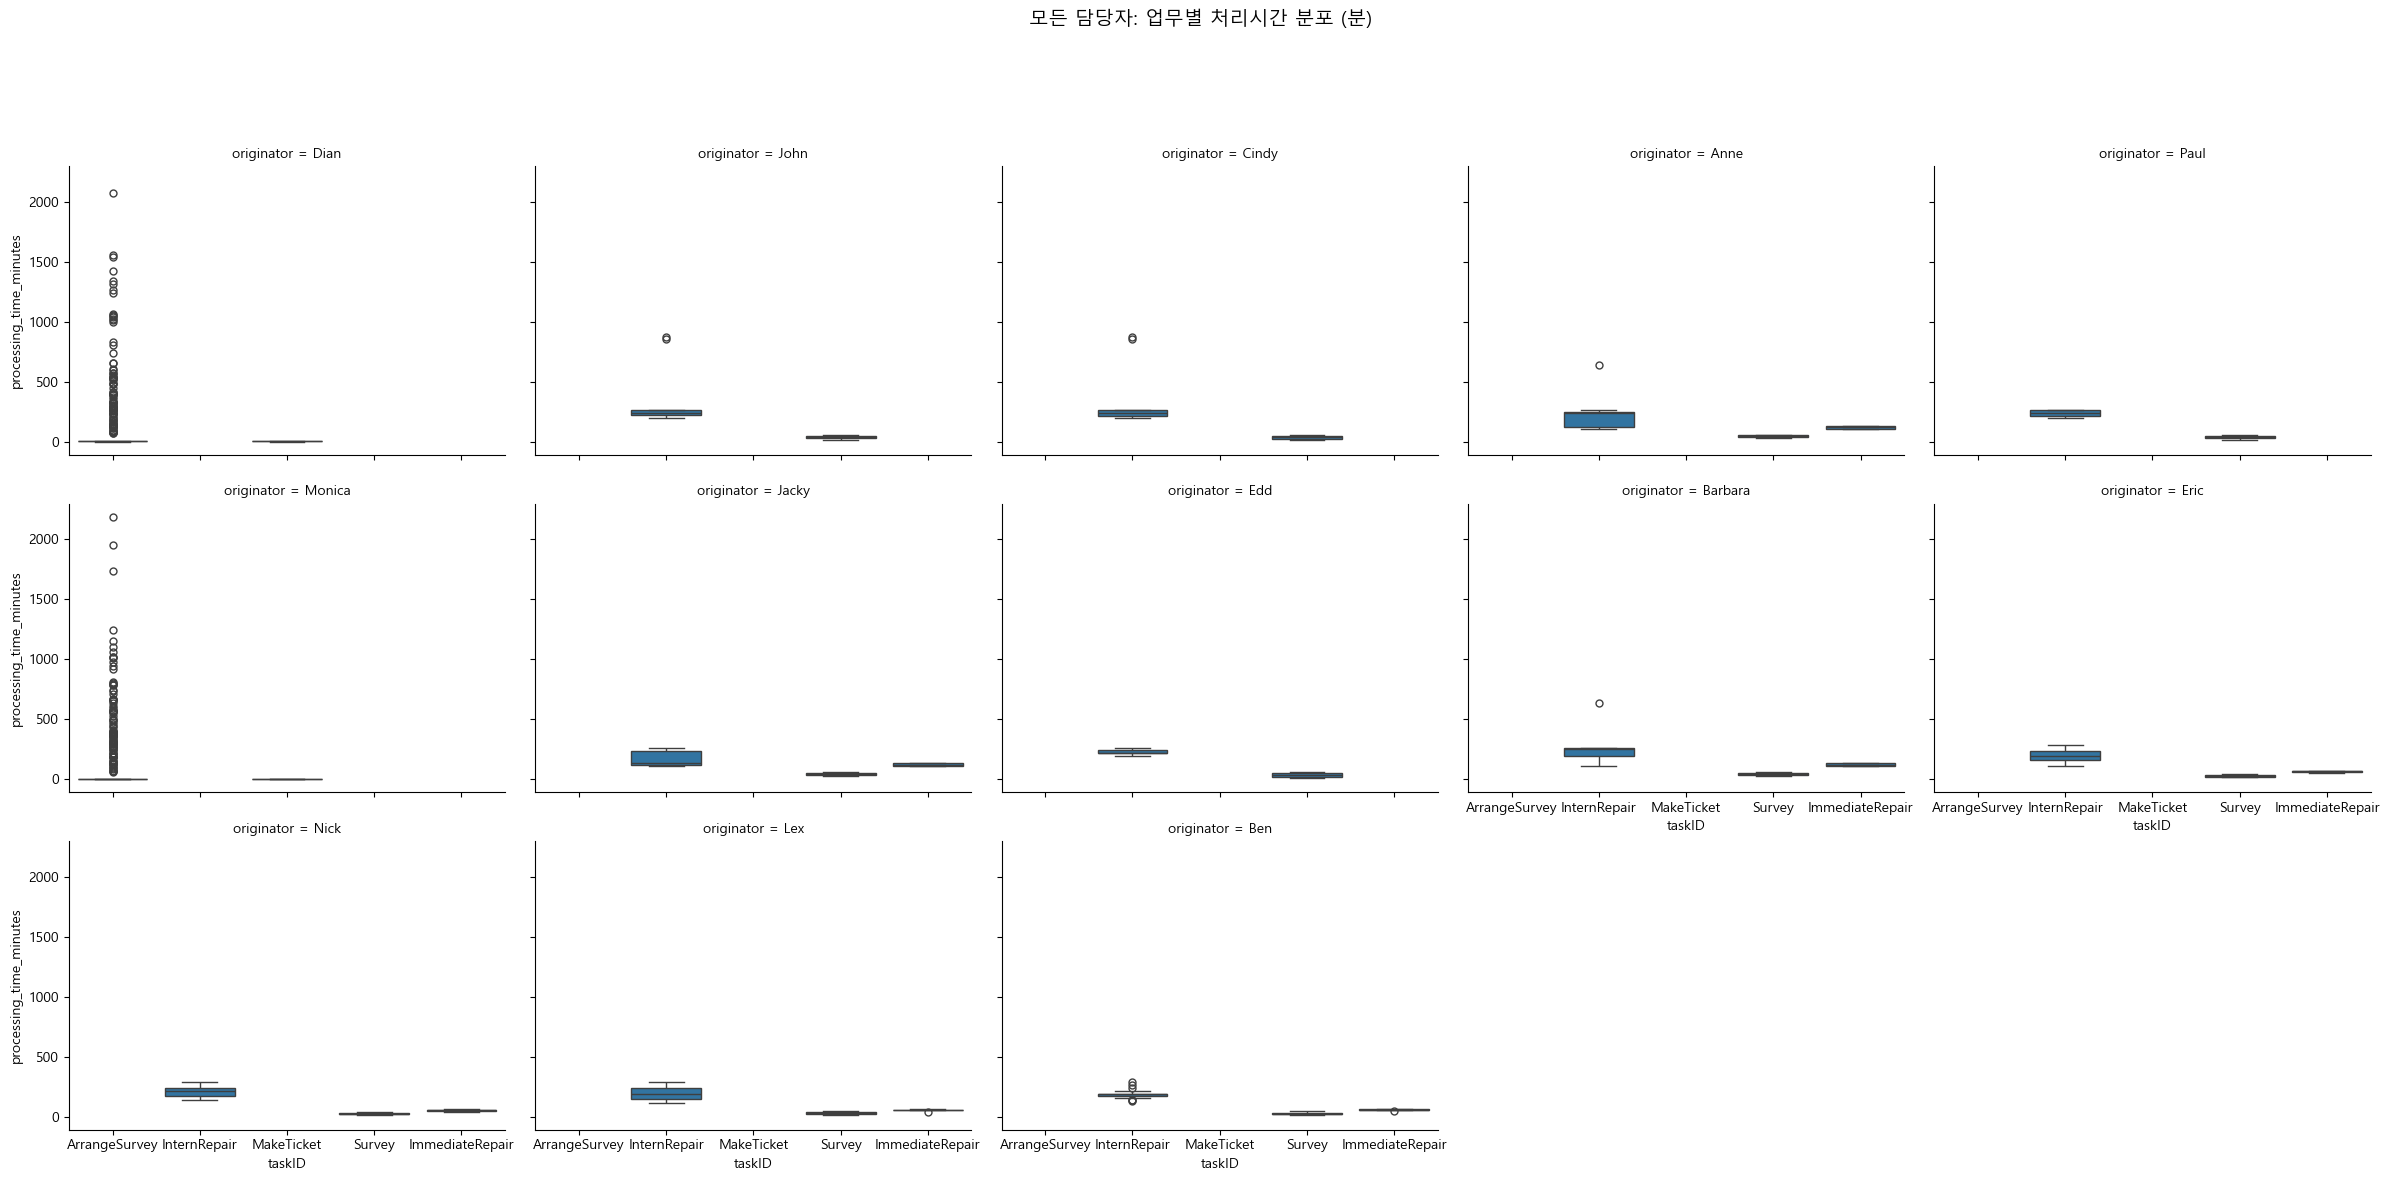

,originator,taskID,count,mean,std,min,25%,50%,75%,max
0,Anne,ImmediateRepair,162.0,119.629630,9.956981,108.0,108.00,120.0,132.00,132.0
1,Anne,InternRepair,27.0,218.370370,104.013368,108.0,126.00,240.0,252.00,640.0
2,Anne,Survey,183.0,45.060109,8.807570,30.0,38.00,45.0,52.50,60.0
3,Barbara,ImmediateRepair,76.0,119.052632,9.751437,108.0,108.00,120.0,132.00,132.0
4,Barbara,InternRepair,12.0,251.333333,136.649075,108.0,195.00,252.0,264.00,640.0
5,Barbara,Survey,98.0,46.295918,8.866954,30.0,39.00,46.5,54.00,60.0
6,Ben,ImmediateRepair,4.0,58.500000,7.549834,48.0,57.00,60.0,61.50,66.0
7,Ben,InternRepair,19.0,192.000000,39.282453,128.0,176.00,192.0,192.00,288.0
8,Ben,Survey,32.0,27.718750,9.169495,16.0,19.75,26.5,35.00,45.0
9,Cindy,InternRepair,77.0,252.285714,102.707282,198.0,216.00,240.0,264.00,871.0


In [23]:
# 만약 processing_time_minutes 컬럼이 없다면 계산
if 'processing_time_minutes' not in df_proc.columns:
    df_proc['processing_time_minutes'] = (df_proc['complete'] - df_proc['start']).dt.total_seconds() / 60

# 모든 담당자에 대해, 그리고 각 담당자의 업무(taskID)별 처리시간(분) 분포를 박스플롯으로 시각화
sns.catplot(
    data=df_proc,
    x='taskID', 
    y='processing_time_minutes', 
    col='originator', 
    kind='box', 
    col_wrap=5, 
    height=4, 
    aspect=1.2
)

plt.subplots_adjust(top=0.85)
plt.suptitle('모든 담당자: 업무별 처리시간 분포 (분)', fontsize=14)
plt.show()

processing_time_stats = df_proc.groupby(['originator', 'taskID'])['processing_time_minutes'].describe().reset_index()

processing_time_stats

##### 내부 수리(InternRepair) 속도 개선 필요
- **John & Cindy**가 가장 많은 수리를 담당하면서도 처리 시간이 길음.
- 최대 **871분**이 소요된 사례 존재 → 내부 수리 절차 개선 필요.

##### 조사 일정 조정(ArrangeSurvey) 속도 개선 필요
- **Monica & Dian**의 평균 처리 시간이 **120분 이상** 소요됨.
- **36시간 이상** 걸린 사례 존재 → 조사 일정 조정의 자동화 또는 최적화 필요.

##### 즉시 수리(ImmediateRepair) 담당자 간 차이 감소 필요
- **Ben, Lex, Nick**은 **50~60분대**로 빠르게 수행.
- **Anne, Jacky**는 **120분 소요** → 즉시 수리를 더 효율적으로 수행할 방법 필요.

##### 조사(Survey) 담당자별 속도 차이 존재 → 표준화 필요
- **Ben, Nick**은 **25~27분대**로 빠르게 처리.
- **John, Cindy**는 **38분 이상 소요** → 표준 조사 방법 검토 필요.
